In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy


C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
at_eur_1h = pd.read_csv('data/indicators_eurusd_d.csv')

In [3]:
at_eur_1h.head()

,Date,Open,High,Low,Close,Name,Return,Up,Down,avg_14up,...,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL
0,2020-01-29,1.10220,1.10277,1.09926,1.10105,EURUSD,-0.001044,0.000000,0.001044,0.000463,...,1.106465,1.110141,-0.003676,1.09926,1.11713,10.016788,-89.983212,1.110335,1.121102,1.099567
1,2020-01-30,1.10103,1.10396,1.10076,1.10341,EURUSD,0.002141,0.002141,0.000000,0.000518,...,1.105995,1.109642,-0.003647,1.09926,1.11713,23.223279,-76.776721,1.109646,1.120332,1.098960
2,2020-01-31,1.10336,1.10916,1.10171,1.10903,EURUSD,0.005080,0.005080,0.000000,0.000792,...,1.106462,1.109597,-0.003135,1.09926,1.11713,54.672636,-45.327364,1.109289,1.119524,1.099054
3,2020-02-03,1.10859,1.10908,1.10369,1.10594,EURUSD,-0.002790,0.000000,0.002790,0.000792,...,1.106382,1.109326,-0.002944,1.09926,1.11713,37.381086,-62.618914,1.108607,1.117710,1.099504
4,2020-02-04,1.10593,1.10641,1.10332,1.10452,EURUSD,-0.001285,0.000000,0.001285,0.000636,...,1.106095,1.108970,-0.002875,1.09926,1.11713,29.434807,-70.565193,1.108094,1.116884,1.099304


### =====================
[Simpful on github](https://github.com/aresio/simpful/blob/master/simpful/simpful.py)
### =====================

## MA decision

kupno - krótsza przecina dłuższą od dołu
sprzedaż - krótsza przecina dłuższą od góry

In [4]:
# Ostre

at_eur_1h['prev_5MA'] = at_eur_1h['5MA'].shift(1)

at_eur_1h['crossover'] = np.where((at_eur_1h['5MA'] > at_eur_1h['15MA']) & (at_eur_1h['prev_5MA'] < at_eur_1h['15MA']), 'bullish crossover',
                                  np.where((at_eur_1h['5MA'] < at_eur_1h['15MA']) & (at_eur_1h['prev_5MA'] > at_eur_1h['15MA']), 'bearish crossover', None))

at_eur_1h['cross_MA'] = np.where(at_eur_1h['crossover'] == 'bullish crossover', 'BUY', 
                                          np.where(at_eur_1h['crossover'] == 'bearish crossover', 'SELL', 'HOLD'))


In [5]:
at_eur_1h['crossover'].value_counts()

crossover
bearish crossover    48
bullish crossover    42
Name: count, dtype: int64

In [6]:
at_eur_1h['cross_MA'].value_counts()

cross_MA
HOLD    926
SELL     48
BUY      42
Name: count, dtype: int64

In [10]:
# Calculating the difference between the shorter and longer average

at_eur_1h['diff_MA'] = at_eur_1h['5MA'] - at_eur_1h['15MA']

# Creation of 1 lagged column with difference in averages
at_eur_1h['diff_MA_prev'] = at_eur_1h['diff_MA'].shift(1)

In [20]:
at_eur_1h['diff_MA'].describe()

count    1016.000000
mean       -0.000045
std         0.007810
min        -0.029564
25%        -0.005209
50%        -0.000063
75%         0.004415
max         0.026791
Name: diff_MA, dtype: float64

In [11]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MA około 0 i diff_MA_prev < 0 - BUY
Jeśli diff_MA około 0 i diff_MA_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MA", LV)
FS.add_linguistic_variable("diff_MA_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MA_strategy", LV)

R1 = "IF (diff_MA IS medium) AND (diff_MA_prev IS low) THEN (fuzz_MA_strategy IS BUY)"
R2 = "IF (diff_MA IS medium) AND (diff_MA_prev IS high) THEN (fuzz_MA_strategy IS SELL)"
R3 = "IF (diff_MA IS low) THEN (fuzz_MA_strategy IS HOLD)"
R4 = "IF (diff_MA IS high) THEN (fuzz_MA_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


at_eur_1h['fuzz_MA_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['diff_MA']):
    FS.set_variable("diff_MA", value)
    FS.set_variable("diff_MA_prev", at_eur_1h.loc[at_eur_1h.index[i], 'diff_MA_prev'])
    decision = FS.Mamdani_inference()['fuzz_MA_strategy']

    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'fuzz_MA_strategy'] = 'BUY'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'fuzz_MA_strategy'] = 'SELL'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



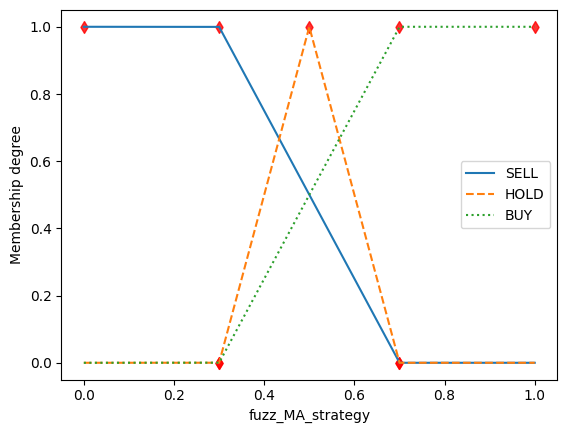

In [12]:
FS.plot_variable('fuzz_MA_strategy')

In [13]:
at_eur_1h['fuzz_MA_strategy'].value_counts()

fuzz_MA_strategy
HOLD    991
SELL     13
BUY      12
Name: count, dtype: int64

## Backtesting

### ========

[Backtesting on github](https://github.com/kernc/backtesting.py/blob/master/backtesting/backtesting.py#L1014)
### ========

## Fuzzy

In [14]:
# zmiana decyzji na -1, 0, 1
at_eur_1h['fuzz_MA_strategy'] = at_eur_1h['fuzz_MA_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


# zmiana na datę
at_eur_1h['Date'] = pd.DatetimeIndex(at_eur_1h['Date'])

In [15]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['fuzz_MA_strategy'])
        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia
bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\AppData\Local\Temp\ipykernel_25100\988956195.py:8: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                                     0.0
End                                    1015.0
Duration                               1015.0
Exposure Time [%]                   85.334646
Equity Final [$]                  9999.939957
Equity Peak [$]                  10000.095743
Return [%]                            -0.0006
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.002258
Avg. Drawdown [%]                   -0.000294
Max. Drawdown Duration                  379.0
Avg. Drawdown Duration              47.555556
# Trades                                 24.0
Win Rate [%]                             62.5
Best Trade [%]                       3.498863
Worst Trade [%]                     -9.963948
Avg. Trade [%]                    

## Sharp

In [17]:
at_eur_1h['cross_MA'] = at_eur_1h['cross_MA'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['cross_MA'])
        

bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\AppData\Local\Temp\ipykernel_25100\813635220.py:9: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                                     0.0
End                                    1015.0
Duration                               1015.0
Exposure Time [%]                   96.555118
Equity Final [$]                 10000.025363
Equity Peak [$]                  10000.045465
Return [%]                           0.000254
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.001525
Avg. Drawdown [%]                   -0.000814
Max. Drawdown Duration                  880.0
Avg. Drawdown Duration             325.666667
# Trades                                 89.0
Win Rate [%]                        42.696629
Best Trade [%]                        4.88003
Worst Trade [%]                     -3.508972
Avg. Trade [%]                    

# MACD

In [19]:
at_eur_1h['Signal_Line'] = at_eur_1h.groupby('Name')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())


In [ ]:
   '''
    Linia MACD przetnie od dołu linię sygnałową - kup
    Linia MACD przetnie od góry linię sygnałową - sprzedaj
    '''

In [25]:

buy_condition = ((at_eur_1h['MACD'].shift(1) < at_eur_1h['Signal_Line'].shift(1)) & 
                 (at_eur_1h['MACD'] > at_eur_1h['Signal_Line']))  
               

sell_condition = ((at_eur_1h['MACD'].shift(1) > at_eur_1h['Signal_Line'].shift(1)) & 
                  (at_eur_1h['MACD'] < at_eur_1h['Signal_Line']))

at_eur_1h['MACD_decision'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))


In [30]:
at_eur_1h[['MACD', 'Signal_Line']].describe()

,MACD,Signal_Line
count,1016.000000,1016.000000
mean,-0.000174,-0.000211
std,0.005867,0.005531
min,-0.014398,-0.011850
25%,-0.004481,-0.004317
50%,-0.001122,-0.001157
75%,0.004012,0.004043
max,0.014833,0.013438


In [27]:
   '''
    Linia MACD przetnie od dołu linię sygnałową - kup
    Linia MACD przetnie od góry linię sygnałową - sprzedaj
    '''

# Calculating the difference between MACD and Signal line
at_eur_1h['diff_MACD'] = at_eur_1h['MACD'] - at_eur_1h['Signal_Line']

# Creation of 1 lagged column with the difference in MACD and Signal
at_eur_1h['diff_MACD_prev'] = at_eur_1h['diff_MACD'].shift(1)



In [28]:
at_eur_1h['diff_MACD'].describe()

count    1016.000000
mean        0.000036
std         0.001731
min        -0.006094
25%        -0.001161
50%         0.000030
75%         0.001153
max         0.006249
Name: diff_MACD, dtype: float64

count    1016.000000
mean       -0.000045
std         0.007810
min        -0.029564
25%        -0.005209
50%        -0.000063
75%         0.004415
max         0.026791
Name: diff_MA, dtype: float64

In [39]:
at_eur_1h['MACD_decision'].value_counts()

MACD_decision
 0    934
-1     41
 1     41
Name: count, dtype: int64

In [33]:
at_eur_1h[['MACD', 'Signal_Line', 'diff_MACD', 'diff_MACD_prev']].head(10)

,MACD,Signal_Line,diff_MACD,diff_MACD_prev
0,-0.003676,-0.003676,0.000000,NaN
1,-0.003647,-0.003670,0.000023,0.000000
2,-0.003135,-0.003563,0.000428,0.000023
3,-0.002944,-0.003439,0.000495,0.000428
4,-0.002875,-0.003326,0.000452,0.000495
5,-0.003149,-0.003291,0.000142,0.000452
6,-0.003478,-0.003328,-0.000150,0.000142
7,-0.003964,-0.003455,-0.000509,-0.000150
8,-0.004588,-0.003682,-0.000906,-0.000509
9,-0.004962,-0.003938,-0.001024,-0.000906


In [35]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MACD około 0 (0,001) i diff_MACD_prev < 0 - BUY
Jeśli diff_MACD około 0(0,001) i diff_MACD_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MACD", LV)
FS.add_linguistic_variable("diff_MACD_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MACD_strategy", LV)

R1 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS low) THEN (fuzz_MACD_strategy IS BUY)"
R2 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS high) THEN (fuzz_MACD_strategy IS SELL)"
R3 = "IF (diff_MACD IS low) THEN (fuzz_MACD_strategy IS HOLD)"
R4 = "IF (diff_MACD IS high) THEN (fuzz_MACD_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


at_eur_1h['fuzz_MACD_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['diff_MACD']):
    FS.set_variable("diff_MACD", value)
    FS.set_variable("diff_MACD_prev", at_eur_1h.loc[at_eur_1h.index[i], 'diff_MACD_prev'])
    decision = FS.Mamdani_inference()['fuzz_MACD_strategy']

    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'fuzz_MACD_strategy'] = 'BUY'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'fuzz_MACD_strategy'] = 'SELL'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



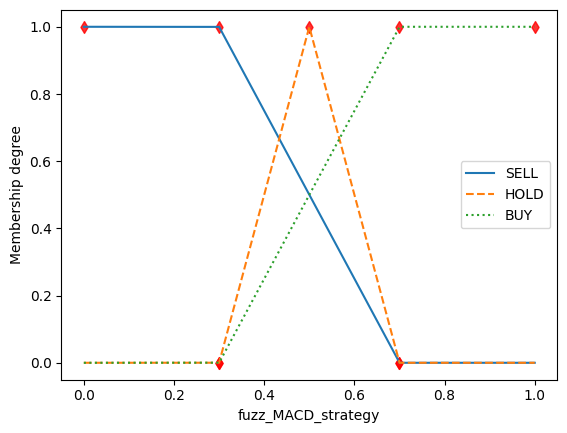

In [36]:
FS.plot_variable('fuzz_MACD_strategy')

In [37]:
at_eur_1h['fuzz_MACD_strategy'].value_counts()

fuzz_MACD_strategy
HOLD    984
SELL     17
BUY      15
Name: count, dtype: int64

# Backtesting

## Fuzzy

In [38]:
at_eur_1h['fuzz_MACD_strategy'] = at_eur_1h['fuzz_MACD_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['fuzz_MACD_strategy'])
        

bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\AppData\Local\Temp\ipykernel_25100\2442180821.py:9: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                                     0.0
End                                    1015.0
Duration                               1015.0
Exposure Time [%]                   98.129921
Equity Final [$]                 10000.169335
Equity Peak [$]                  10000.255303
Return [%]                           0.001693
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.000903
Avg. Drawdown [%]                   -0.000191
Max. Drawdown Duration                  481.0
Avg. Drawdown Duration                30.1875
# Trades                                 31.0
Win Rate [%]                        64.516129
Best Trade [%]                       8.518363
Worst Trade [%]                     -5.088735
Avg. Trade [%]                    

## Sharp

In [40]:

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['MACD_decision'])
        

bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\AppData\Local\Temp\ipykernel_25100\2425482516.py:7: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                                     0.0
End                                    1015.0
Duration                               1015.0
Exposure Time [%]                   98.031496
Equity Final [$]                  9999.796866
Equity Peak [$]                  10000.053614
Return [%]                          -0.002031
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.003487
Avg. Drawdown [%]                   -0.001182
Max. Drawdown Duration                  987.0
Avg. Drawdown Duration             330.333333
# Trades                                 81.0
Win Rate [%]                        30.864198
Best Trade [%]                       3.881726
Worst Trade [%]                     -2.995407
Avg. Trade [%]                    